In [1]:
!pip install -q pandas_datareader

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader.data as web
import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Load the Data

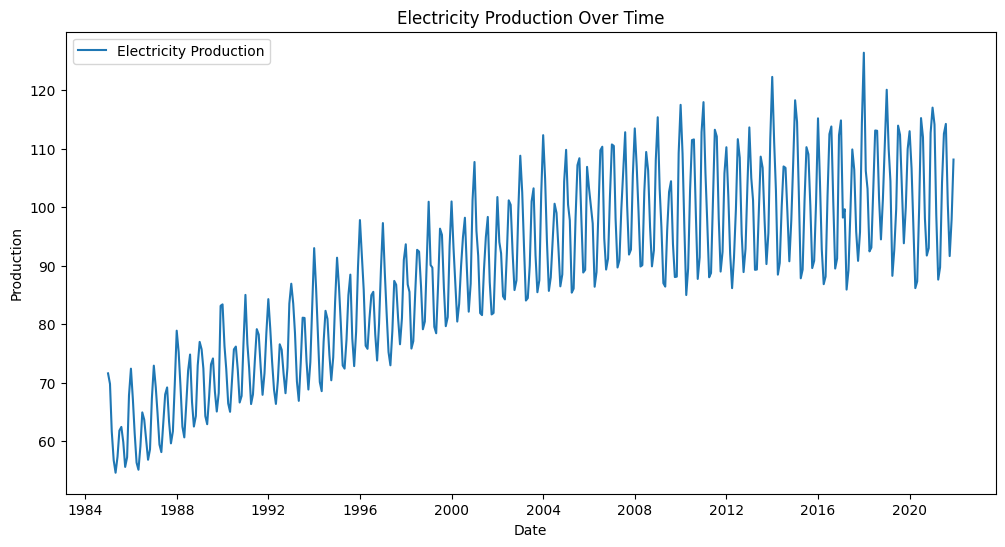

In [3]:
def load_and_explore_data(target_variable='IPG2211A2N'):
    """
    Load the dataset from FRED and plot the time series.

    Parameters:
    - target_variable: The target variable in the dataset.

    Returns:
    - data: Pandas DataFrame with the loaded data.
    """
    # Define the date range for the data
    start_date = datetime.datetime(1985, 1, 1)
    end_date = datetime.datetime(2021, 12, 31)

    # Load the data from FRED
    data = web.DataReader(target_variable, 'fred', start_date, end_date)
    data.dropna(inplace=True)

    # Plot the time series
    plt.figure(figsize=(12, 6))
    plt.plot(data[target_variable], label='Electricity Production')
    plt.title('Electricity Production Over Time')
    plt.xlabel('Date')
    plt.ylabel('Production')
    plt.legend()
    plt.show()

    return data

# Load and explore data
data = load_and_explore_data()

# Preprocess the Data

In [4]:
def preprocess_and_engineer_features(data, target_variable='IPG2211A2N', add_quadratic_terms=True, seasonality_terms=True):
    """
    Create lag features, quadratic terms, and seasonal components.

    Parameters:
    - data: Pandas DataFrame with the time series data.
    - target_variable: The target variable in the dataset.
    - add_quadratic_terms: Boolean to include quadratic terms.
    - seasonality_terms: Boolean to include seasonal terms.

    Returns:
    - X: Feature matrix.
    - y: Target variable array.
    """
    y = data[target_variable].values
    n = len(y)
    X = []

    # Create lag features
    for lag in range(1, 6):
        X.append(y[(5 - lag):-lag])

    # Add quadratic terms
    if add_quadratic_terms:
        for i in range(3):
            X.append(X[i] ** 2)

    # Add seasonal terms
    if seasonality_terms:
        months = data.index.month[5:]
        seasonal_sin = np.sin(2 * np.pi * months / 12)
        seasonal_cos = np.cos(2 * np.pi * months / 12)
        X.append(seasonal_sin)
        X.append(seasonal_cos)

    X = np.column_stack(X)
    y = y[5:]
    return X, y

# Preprocess and engineer features
X_full, y_full = preprocess_and_engineer_features(data)

# Initial Model Training

In [5]:
def train_initial_model(X, y, initial_points=100, holdout_points=12):
    """
    Train the initial linear regression model.

    Parameters:
    - X: Feature matrix.
    - y: Target variable array.
    - initial_points: Number of initial training points.
    - holdout_points: Number of validation points.

    Returns:
    - model: Trained LinearRegression model.
    - X_train: Training feature matrix.
    - y_train: Training target array.
    - X_valid: Validation feature matrix.
    - y_valid: Validation target array.
    - y_pred_valid: Predictions on the validation set.
    """
    # Split the data
    X_train = X[:initial_points]
    y_train = y[:initial_points]
    X_valid = X[initial_points:initial_points + holdout_points]
    y_valid = y[initial_points:initial_points + holdout_points]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred_valid = model.predict(X_valid)
    validation_error = mean_squared_error(y_valid, y_pred_valid)

    print(f'Initial validation MSE: {validation_error:.4f}')

    return model, X_train, y_train, X_valid, y_valid, y_pred_valid

# Train the initial model
model, X_train, y_train, X_valid, y_valid, y_pred_valid = train_initial_model(X_full, y_full)

Initial validation MSE: 7.4446


# Dynamic Model Updating

In [6]:
def dynamic_model_update(model, X_train, y_train, X_full, y_full, X_valid, y_valid, step_size=1, early_stop_rounds=3, verbose=True):
    """
    Dynamically update the model by adding new data points using the Sherman-Morrison formula.

    Parameters:
    - model: The initial trained LinearRegression model.
    - X_train: Training feature matrix.
    - y_train: Training target array.
    - X_full: Full feature matrix.
    - y_full: Full target array.
    - X_valid: Validation feature matrix.
    - y_valid: Validation target array.
    - step_size: Number of data points to add in each update.
    - early_stop_rounds: Number of rounds without improvement to stop early.
    - verbose: Boolean to print progress.

    Returns:
    - model: Updated LinearRegression model.
    - validation_errors: List of validation errors after each update.
    """
    from numpy.linalg import inv

    # Compute initial A_inv
    A_inv = inv(X_train.T @ X_train)
    best_error = mean_squared_error(y_valid, model.predict(X_valid))
    worse_count = 0
    validation_errors = [best_error]

    # Start updating from the point after the initial training data
    current_index = X_train.shape[0]

    while current_index < X_full.shape[0] - len(y_valid):
        # New data points
        X_new = X_full[current_index:current_index + step_size]
        y_new = y_full[current_index:current_index + step_size]
        current_index += step_size

        # Update A_inv using Sherman-Morrison formula
        for i in range(step_size):
            x_i = X_new[i].reshape(-1, 1)
            A_inv = A_inv - (A_inv @ x_i @ x_i.T @ A_inv) / (1 + x_i.T @ A_inv @ x_i)

        # Update model coefficients
        X_train = np.vstack([X_train, X_new])
        y_train = np.concatenate([y_train, y_new])
        coef = A_inv @ X_train.T @ y_train
        model.coef_ = coef
        model.intercept_ = 0  # Intercept is 0 because data is not centered

        # Evaluate on validation set
        y_pred_valid = X_valid @ model.coef_
        validation_error = mean_squared_error(y_valid, y_pred_valid)
        validation_errors.append(validation_error)

        if verbose:
            print(f'Step {current_index}: Validation MSE: {validation_error:.4f}')

        # Early stopping
        if validation_error < best_error:
            best_error = validation_error
            worse_count = 0
        else:
            worse_count += 1
            if worse_count >= early_stop_rounds:
                if verbose:
                    print('Early stopping due to no improvement.')
                break

    return model, validation_errors

# Perform dynamic model updating
model_updated, validation_errors = dynamic_model_update(
    model, X_train, y_train, X_full, y_full, X_valid, y_valid)

Step 101: Validation MSE: 5.2589
Step 102: Validation MSE: 5.0685
Step 103: Validation MSE: 5.0243
Step 104: Validation MSE: 3.9949
Step 105: Validation MSE: 4.0521
Step 106: Validation MSE: 3.5667
Step 107: Validation MSE: 3.5075
Step 108: Validation MSE: 3.5237
Step 109: Validation MSE: 3.4879
Step 110: Validation MSE: 3.4971
Step 111: Validation MSE: 3.4674
Step 112: Validation MSE: 3.4181
Step 113: Validation MSE: 3.3976
Step 114: Validation MSE: 3.3799
Step 115: Validation MSE: 3.3502
Step 116: Validation MSE: 3.0773
Step 117: Validation MSE: 3.0855
Step 118: Validation MSE: 3.1143
Step 119: Validation MSE: 3.0986
Early stopping due to no improvement.


# Model Performance

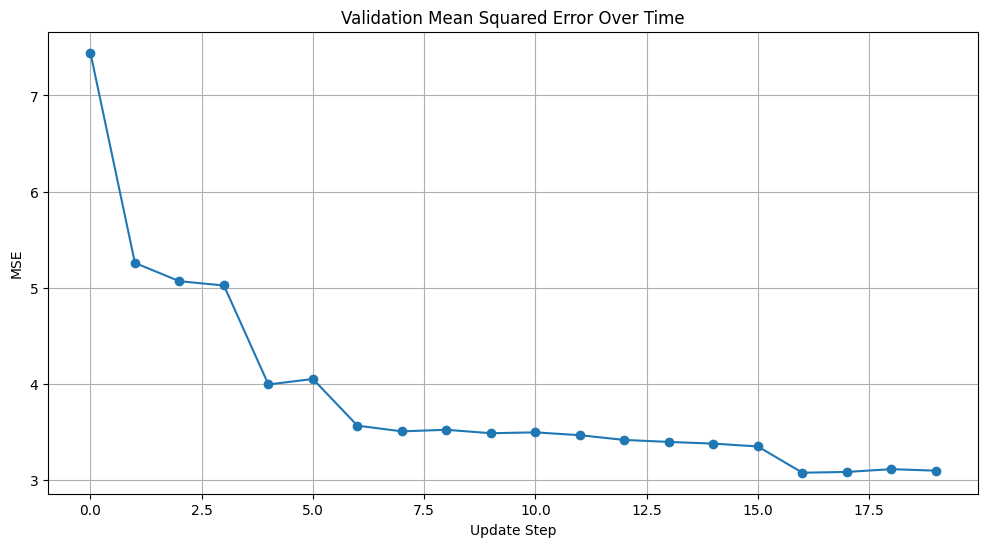

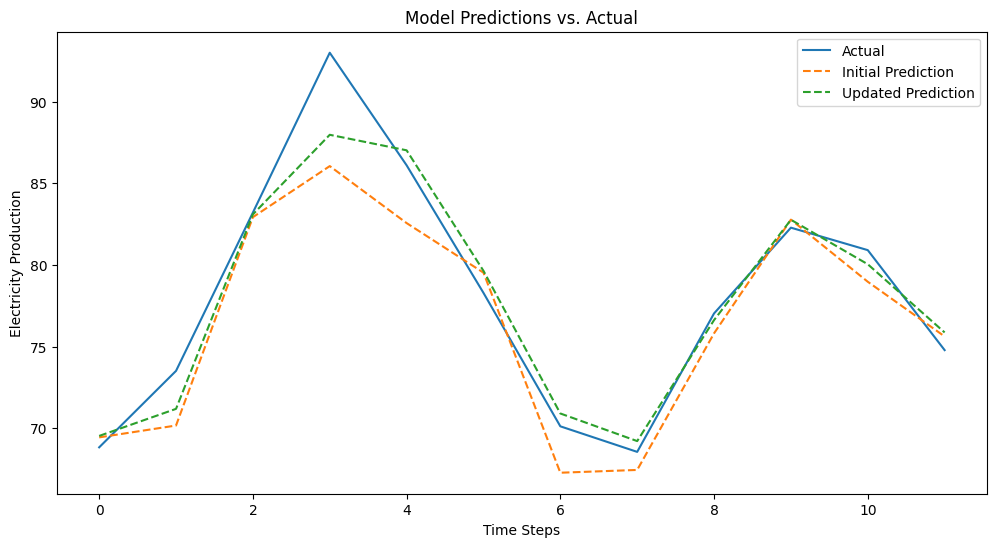

In [7]:
def plot_validation_error(validation_errors):
    """
    Plot the validation mean squared error over time.

    Parameters:
    - validation_errors: List of validation errors after each update.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(validation_errors, marker='o')
    plt.title('Validation Mean Squared Error Over Time')
    plt.xlabel('Update Step')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()

def plot_predictions(y_valid, y_pred_initial, y_pred_updated):
    """
    Plot the actual vs predicted values.

    Parameters:
    - y_valid: Actual validation target values.
    - y_pred_initial: Predictions from the initial model.
    - y_pred_updated: Predictions from the updated model.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_valid, label='Actual')
    plt.plot(y_pred_initial, label='Initial Prediction', linestyle='--')
    plt.plot(y_pred_updated, label='Updated Prediction', linestyle='--')
    plt.title('Model Predictions vs. Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Electricity Production')
    plt.legend()
    plt.show()

# Plot validation error over time
plot_validation_error(validation_errors)

# Predict with the updated model
y_pred_updated = X_valid @ model_updated.coef_

# Plot predictions
plot_predictions(y_valid, y_pred_valid, y_pred_updated)

# Neural Network with Incremental Learning

In [8]:
def relu(z):
    """
    ReLU activation function.
    """
    return np.maximum(0, z)

def relu_derivative(z):
    """
    Derivative of the ReLU function.
    """
    return (z > 0).astype(float)

def loss(y, y_pred):
    """
    Mean squared error loss function.
    """
    return np.mean((y - y_pred) ** 2)

In [9]:
def forward_pass(x, W1, b1, W2, b2):
    """
    Perform a forward pass through the network.

    Parameters:
    - x: Input data.
    - W1, b1: Weights and biases for the hidden layer.
    - W2, b2: Weights and biases for the output layer.

    Returns:
    - y_pred: Network output.
    - z1: Linear combination at hidden layer.
    - a1: Activation at hidden layer.
    """
    z1 = W1 @ x + b1
    a1 = relu(z1)
    z2 = W2 @ a1 + b2
    y_pred = z2  # Linear activation for regression
    return y_pred, z1, a1

def backward_pass(x, y, y_pred, z1, a1, W2):
    """
    Perform a backward pass and compute gradients.

    Parameters:
    - x: Input data.
    - y: True target values.
    - y_pred: Predicted values.
    - z1: Linear combination at hidden layer.
    - a1: Activation at hidden layer.
    - W2: Weights for the output layer.

    Returns:
    - dW1, db1: Gradients for weights and biases of hidden layer.
    - dW2, db2: Gradients for weights and biases of output layer.
    """
    m = x.shape[1]  # Number of samples
    dz2 = y_pred - y  # (output_size, m)
    dW2 = (dz2 @ a1.T) / m
    db2 = np.sum(dz2, axis=1, keepdims=True) / m
    da1 = W2.T @ dz2
    dz1 = da1 * relu_derivative(z1)
    dW1 = (dz1 @ x.T) / m
    db1 = np.sum(dz1, axis=1, keepdims=True) / m
    return dW1, db1, dW2, db2

In [10]:
def update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    """
    Update the network weights and biases.

    Parameters:
    - W1, b1, W2, b2: Current weights and biases.
    - dW1, db1, dW2, db2: Computed gradients.
    - learning_rate: Learning rate for updates.

    Returns:
    - W1, b1, W2, b2: Updated weights and biases.
    """
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

def initialize_neural_network(input_size, hidden_units=50, output_size=1):
    """
    Initialize the neural network weights and biases.

    Parameters:
    - input_size: Number of input features.
    - hidden_units: Number of neurons in the hidden layer.
    - output_size: Number of output units.

    Returns:
    - W1, b1, W2, b2: Initialized weights and biases.
    """
    W1 = np.random.randn(hidden_units, input_size) * np.sqrt(2 / input_size)
    b1 = np.zeros((hidden_units, 1))
    W2 = np.random.randn(output_size, hidden_units) * np.sqrt(2 / hidden_units)
    b2 = np.zeros((output_size, 1))
    return W1, b1, W2, b2

In [11]:
def train_neural_network(X_train, y_train, input_size, hidden_units=50, epochs=2000, learning_rate=0.001):
    """
    Train the neural network.

    Parameters:
    - X_train: Training feature matrix.
    - y_train: Training target array.
    - input_size: Number of input features.
    - hidden_units: Number of neurons in the hidden layer.
    - epochs: Number of training epochs.
    - learning_rate: Learning rate for updates.

    Returns:
    - W1, b1, W2, b2: Updated weights and biases.
    - loss_history: List of training losses.
    """
    # Initialize weights
    W1, b1, W2, b2 = initialize_neural_network(input_size, hidden_units)

    m = X_train.shape[0]
    loss_history = []

    for epoch in range(epochs):
        # Forward pass
        y_pred, z1, a1 = forward_pass(X_train.T, W1, b1, W2, b2)

        # Compute loss
        train_loss = loss(y_train.T, y_pred)
        loss_history.append(train_loss)

        # Backward pass
        dW1, db1, dW2, db2 = backward_pass(X_train.T, y_train.T, y_pred, z1, a1, W2)

        # Update weights
        W1, b1, W2, b2 = update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}, Loss: {train_loss:.5f}')

    return W1, b1, W2, b2, loss_history

In [12]:
# Prepare data for neural network
def prepare_nn_data(X, y, initial_points=100, holdout_points=12):
    """
    Scale and split the data for the neural network.

    Parameters:
    - X: Feature matrix.
    - y: Target variable array.
    - initial_points: Number of initial training points.
    - holdout_points: Number of validation points.

    Returns:
    - X_train_nn: Scaled training features.
    - y_train_nn: Scaled training targets.
    - X_valid_nn: Scaled validation features.
    - y_valid_nn: Scaled validation targets.
    - scaler_X: Scaler for features.
    - scaler_y: Scaler for target variable.
    """
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    scaler_y = MinMaxScaler(feature_range=(-1, 1))

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    X_train_nn = X_scaled[:initial_points]
    y_train_nn = y_scaled[:initial_points]
    X_valid_nn = X_scaled[initial_points:initial_points + holdout_points]
    y_valid_nn = y_scaled[initial_points:initial_points + holdout_points]

    return X_train_nn, y_train_nn, X_valid_nn, y_valid_nn, scaler_X, scaler_y

In [13]:
# Prepare data
X_train_nn, y_train_nn, X_valid_nn, y_valid_nn, scaler_X, scaler_y = prepare_nn_data(X_full, y_full)

# Get input size from X_train_nn
input_size = X_train_nn.shape[1]

# Train neural network
W1, b1, W2, b2, loss_history = train_neural_network(X_train_nn, y_train_nn, input_size)

Epoch 100, Loss: 0.14043
Epoch 200, Loss: 0.12373
Epoch 300, Loss: 0.11268
Epoch 400, Loss: 0.10438
Epoch 500, Loss: 0.09783
Epoch 600, Loss: 0.09241
Epoch 700, Loss: 0.08779
Epoch 800, Loss: 0.08370
Epoch 900, Loss: 0.07998
Epoch 1000, Loss: 0.07653
Epoch 1100, Loss: 0.07333
Epoch 1200, Loss: 0.07031
Epoch 1300, Loss: 0.06743
Epoch 1400, Loss: 0.06467
Epoch 1500, Loss: 0.06206
Epoch 1600, Loss: 0.05959
Epoch 1700, Loss: 0.05728
Epoch 1800, Loss: 0.05507
Epoch 1900, Loss: 0.05297
Epoch 2000, Loss: 0.05099


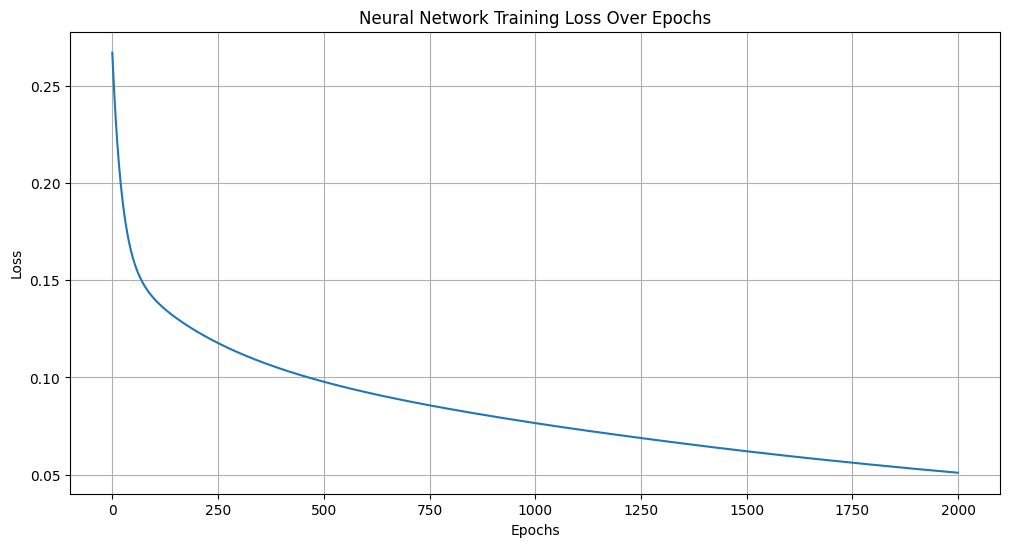

In [14]:
# Plot training loss
def plot_nn_loss(loss_history):
    """
    Plot the training loss over epochs.

    Parameters:
    - loss_history: List of training losses.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(loss_history)
    plt.title('Neural Network Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_nn_loss(loss_history)

# Neural Network Dynamic Updating

In [15]:
def dynamic_update_neural_network(W1, b1, W2, b2, X_scaled, y_scaled, X_valid_nn, y_valid_nn, scaler_y, start_point, step_size=1, early_stop_rounds=3, learning_rate=0.001):
    """
    Dynamically update the neural network with new data points.

    Parameters:
    - W1, b1, W2, b2: Initial weights and biases.
    - X_scaled: Scaled full feature matrix.
    - y_scaled: Scaled full target array.
    - X_valid_nn: Scaled validation features.
    - y_valid_nn: Scaled validation targets.
    - scaler_y: Scaler for target variable.
    - start_point: Index to start adding new data points.
    - step_size: Number of data points to add in each update.
    - early_stop_rounds: Number of rounds without improvement to stop early.
    - learning_rate: Learning rate for updates.

    Returns:
    - W1, b1, W2, b2: Updated weights and biases.
    - validation_errors: List of validation errors after each update.
    """
    best_error = float('inf')
    worse_count = 0
    validation_errors = []
    step_number = 1  # For adjusted step numbering

    current_index = start_point

    while current_index < X_scaled.shape[0] - len(y_valid_nn):
        # New data point
        X_new = X_scaled[current_index:current_index + step_size].T
        y_new = y_scaled[current_index:current_index + step_size].T
        current_index += step_size

        # Forward pass
        y_pred_new, z1_new, a1_new = forward_pass(X_new, W1, b1, W2, b2)

        # Backward pass
        dW1_new, db1_new, dW2_new, db2_new = backward_pass(X_new, y_new, y_pred_new, z1_new, a1_new, W2)

        # Update weights
        W1, b1, W2, b2 = update_weights(W1, b1, W2, b2, dW1_new, db1_new, dW2_new, db2_new, learning_rate)

        # Evaluate on validation set
        y_pred_valid, _, _ = forward_pass(X_valid_nn.T, W1, b1, W2, b2)
        y_pred_valid_rescaled = scaler_y.inverse_transform(y_pred_valid.T)
        y_valid_rescaled = scaler_y.inverse_transform(y_valid_nn)
        validation_error = mean_squared_error(y_valid_rescaled, y_pred_valid_rescaled)
        validation_errors.append(validation_error)

        print(f'Step {step_number}, Validation MSE: {validation_error:.4f}')
        step_number += 1

        # Early stopping
        if validation_error < best_error:
            best_error = validation_error
            worse_count = 0
        else:
            worse_count += 1
            if worse_count >= early_stop_rounds:
                print('Early stopping due to no improvement.')
                break

    return W1, b1, W2, b2, validation_errors

# Dynamic update of neural network
start_point = X_train_nn.shape[0]
W1_updated, b1_updated, W2_updated, b2_updated, nn_validation_errors = dynamic_update_neural_network(
    W1, b1, W2, b2, scaler_X.transform(X_full), scaler_y.transform(y_full.reshape(-1, 1)), X_valid_nn, y_valid_nn, scaler_y, start_point)

Step 1, Validation MSE: 121.5770
Step 2, Validation MSE: 121.6046
Step 3, Validation MSE: 120.4140
Step 4, Validation MSE: 116.8670
Step 5, Validation MSE: 115.1647
Step 6, Validation MSE: 114.2412
Step 7, Validation MSE: 114.8241
Step 8, Validation MSE: 115.1411
Step 9, Validation MSE: 115.5454
Early stopping due to no improvement.


# Neural Network Performance

In [16]:
def plot_nn_validation_errors(validation_errors):
    """
    Plot the validation mean squared error over updates.

    Parameters:
    - validation_errors: List of validation errors after each update.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(validation_errors, marker='o')
    plt.title('Neural Network Validation MSE Over Updates')
    plt.xlabel('Update Step')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()

def plot_nn_predictions(y_valid, y_pred_initial, y_pred_updated):
    """
    Plot the neural network predictions vs actual values.

    Parameters:
    - y_valid: Actual validation target values.
    - y_pred_initial: Predictions from the initial neural network.
    - y_pred_updated: Predictions from the updated neural network.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_valid, label='Actual')
    plt.plot(y_pred_initial, label='Initial NN Prediction', linestyle='--')
    plt.plot(y_pred_updated, label='Updated NN Prediction', linestyle='--')
    plt.title('Neural Network Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Electricity Production')
    plt.legend()
    plt.show()

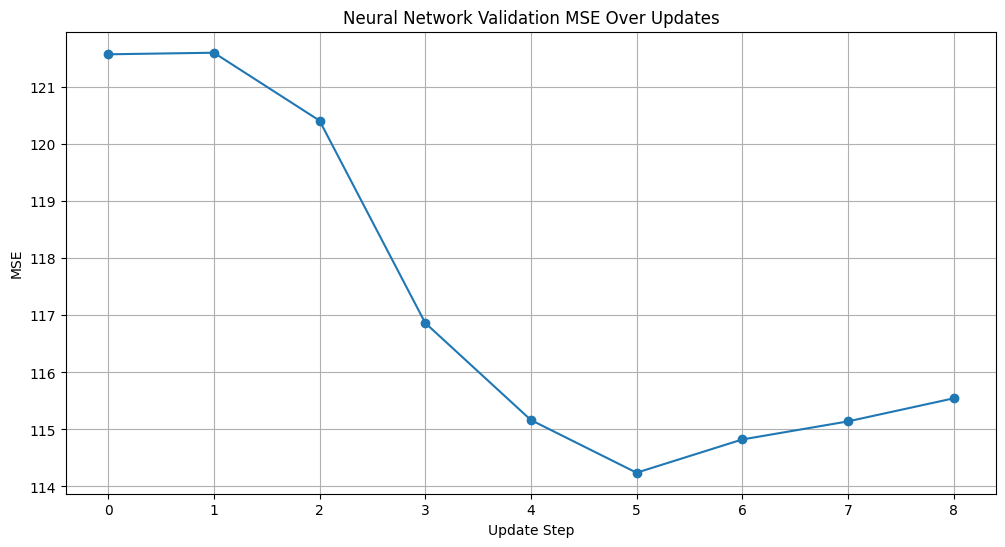

In [17]:
# Plot validation errors over updates
plot_nn_validation_errors(nn_validation_errors)

In [18]:
# Predict with the initial neural network
y_pred_initial_nn, _, _ = forward_pass(X_valid_nn.T, W1, b1, W2, b2)
y_pred_initial_nn_rescaled = scaler_y.inverse_transform(y_pred_initial_nn.T)

# Predict with the updated neural network
y_pred_updated_nn, _, _ = forward_pass(X_valid_nn.T, W1_updated, b1_updated, W2_updated, b2_updated)
y_pred_updated_nn_rescaled = scaler_y.inverse_transform(y_pred_updated_nn.T)

# Inverse transform y_valid_nn
y_valid_rescaled = scaler_y.inverse_transform(y_valid_nn)

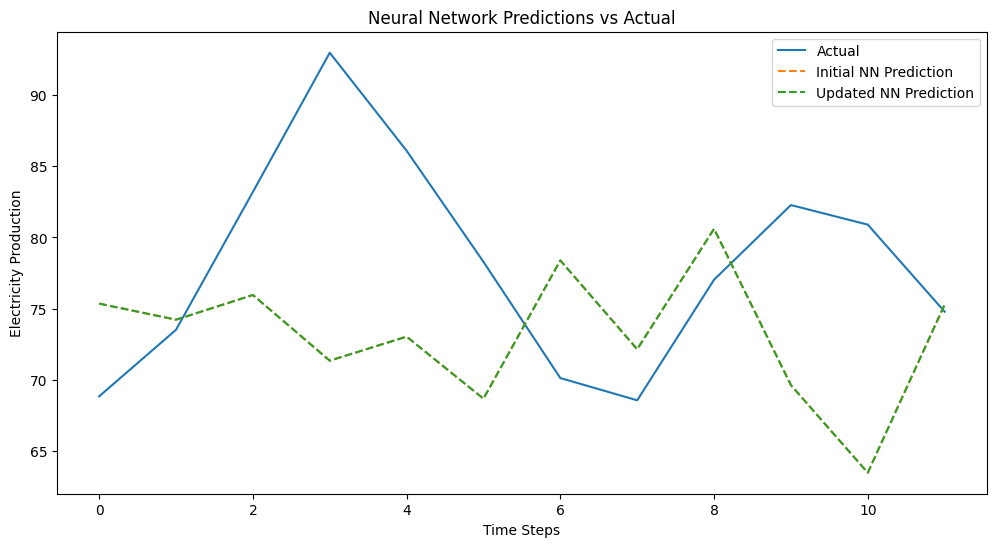

In [19]:
# Plot neural network predictions
plot_nn_predictions(y_valid_rescaled.flatten(), y_pred_initial_nn_rescaled.flatten(), y_pred_updated_nn_rescaled.flatten())